# <center>Определение возраста покупателей</center>

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы и контролировать добросовестность кассиров при продаже алкоголя. Строится модель, которая по фотографии определит приблизительный возраст человека.

**Поставленные задачи:**
* Провести исследовательский анализ данных
* Подготовить модель машинного обучения на базе нейросети, определяющую примерный возраст покупателя по фотографии. В качестве метрики использовать: **МАЕ ⩽ 8**

**Ход работы**

1. [Загрузка данных и исследовательский анализ](#Исследовательский-анализ-данных)
2. [Обучение модели](#Обучение-модели)
3. [Анализ модели](#Анализ-модели)
4. [Вывод](#Вывод)

# Загрузка необходимых модулей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

## Исследовательский анализ данных

In [2]:
# загружаем таблицу с данными
ages = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# инициализируем загрузчик данных
datagen = ImageDataGenerator(rescale=1./255)

In [4]:
datagen_flow = datagen.flow_from_dataframe(
        dataframe=ages,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345
)

Found 7591 validated image filenames.


In [5]:
features, target = next(datagen_flow)

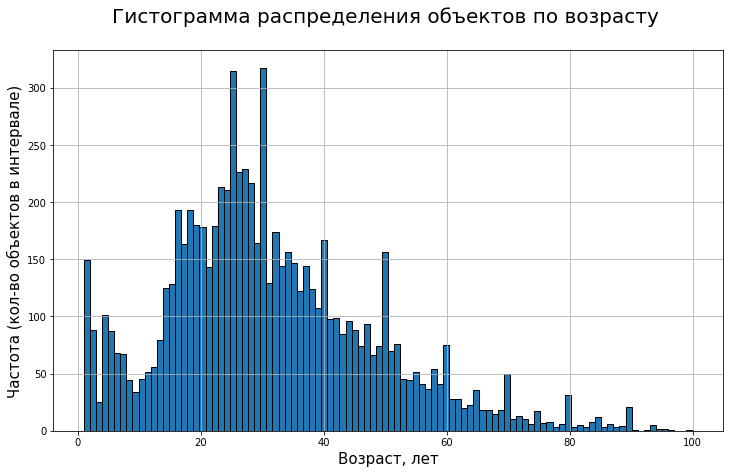

In [6]:
plt.figure(figsize=(12, 7))
plt.hist(ages['real_age'], bins=100, edgecolor="black")
plt.title('Гистограмма распределения объектов по возрасту \n', fontdict={'fontsize': 20})
plt.xlabel('Возраст, лет', fontdict={'fontsize': 15})
plt.ylabel('Частота (кол-во объектов в интервале)', fontdict={'fontsize': 15})
plt.grid()
plt.show()

In [7]:
display(pd.DataFrame(round(ages['real_age'].describe(), 2)))

,real_age
count,7591.00
mean,31.20
std,17.15
min,1.00
25%,20.00
50%,29.00
75%,41.00
max,100.00


Медианное значение: 29 лет  
Среднее значение: 31 год  
  
На гистограмме мы наблюдаем **преобладание** людей с возрастом в диапазоне от 1 до 10 лет и около 30 лет, предположительно из-за округления в процессе составления датасета.

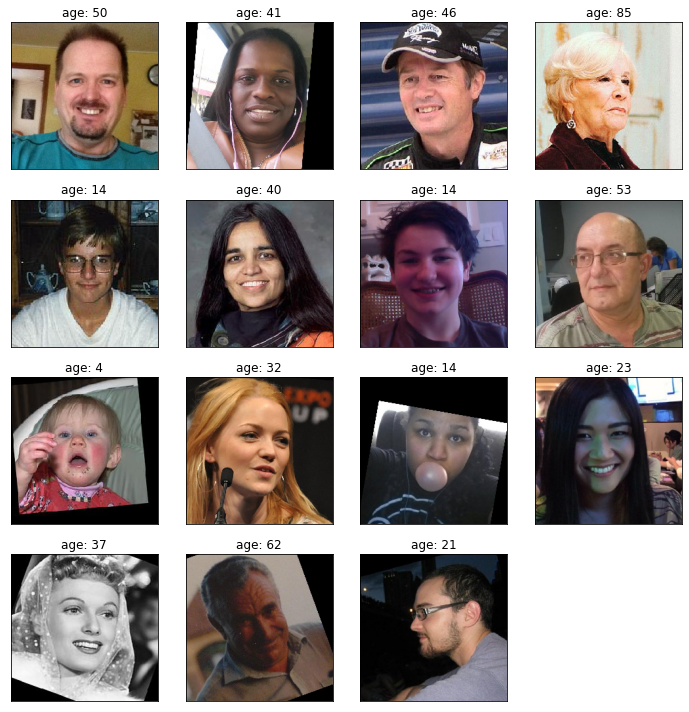

In [8]:
# проверим корректность загрузки фотографий

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.title(f'age: {target[i]}')
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:** данные загруженны корректно. В датасете пристуствует некоторое кол-во чёрно-белых изображений - **color_mode** оставляем равным rgb. Так же к некоторым изображениям применили поворот под углом. Аугментация **rotation_range** не требуется. Фактические размеры изображений различаются, стоит применить **target_size**. Приступим к созданию модели.

## Обучение модели

<font size="4">Описание проделанной работы</font>

Создавая модель я использовал следующие компоненты:
1. Нейросеть с архитектурой **ResNet50**
2. Загрузчик данных **ImageDataGenerator** с встроенными аугментациями
3. Алгоритм **Adam** в качестве оптимизатора целевой функции  

Было испытано несколько вариантов вариации параметров аугментаций и скорости обучения, задающейся в классе **Adam**'а. Аугментации - это некоторые изменения информации составляющей изображение, с целью улучшения обобщающей способности модели. Применены следующие аугментации:
* **horizontal_flip** (горизонтальный разворот)
* **width_shift_range, height_shift_range** (вертикальный и горизонтальный сдвиг)  

Модель имела склонность к переобучению, поэтому скорость была снижена и добавлен слой **Dropout**, случайно отключающий часть нейронов для улучшения обобщающей способности других, а так же регуляризация **l2**.

В ячейке ниже размещён код, загруженный на предоставленный сервер с **NVIDIA Tesla V100** 32GB в качестве вычислительного устройства:

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd

# =============================================================================

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1. / 255,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        dataframe=labels,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)
    
    return train_datagen_flow

# =============================================================================

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1. / 255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        dataframe=labels,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)
    
    return test_datagen_flow

# =============================================================================

def create_model(input_shape=(224, 224, 3)):
    # загрузка ResNet
    backbone = ResNet50(input_shape=input_shape,
                        include_top=False,
                        weights='imagenet')
    
    # заморозка ResNet
    # backbone.trainable = False
        
    # пропись модели
    model = Sequential()
    model.add(backbone)
    model.add(Dropout(0.3))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu', kernel_regularizer='l2'))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=0.00015),
                  metrics=['mae'])

    return model

# =============================================================================

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
       steps_per_epoch = len(train_data)
    if validation_steps is None:
       validation_steps = len(test_data)
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 178 steps, validate for 60 steps

Epoch 1/15
178/178 - 97s - loss: 279.7740 - mae: 12.2330 - val_loss: 649.0305 - val_mae: 20.3905
Epoch 2/15
178/178 - 89s - loss: 137.0476 - mae: 8.9397 - val_loss: 440.6882 - val_mae: 15.8299
Epoch 3/15
178/178 - 89s - loss: 119.5852 - mae: 8.3106 - val_loss: 377.5536 - val_mae: 14.4928
Epoch 4/15
178/178 - 89s - loss: 106.5557 - mae: 7.8068 - val_loss: 208.3511 - val_mae: 10.9760
Epoch 5/15
178/178 - 91s - loss: 98.6767 - mae: 7.5190 - val_loss: 158.9981 - val_mae: 9.4413
Epoch 6/15
178/178 - 92s - loss: 90.4504 - mae: 7.2229 - val_loss: 112.2081 - val_mae: 8.0951
Epoch 7/15
178/178 - 96s - loss: 85.1651 - mae: 6.9912 - val_loss: 145.9168 - val_mae: 9.0714
Epoch 8/15
178/178 - 95s - loss: 80.1569 - mae: 6.7959 - val_loss: 113.5267 - val_mae: 7.8447
Epoch 9/15
178/178 - 92s - loss: 78.0053 - mae: 6.7054 - val_loss: 103.8506 - val_mae: 7.9145
Epoch 10/15
178/178 - 92s - loss: 71.1896 - mae: 6.4298 - val_loss: 129.5729 - val_mae: 8.6742
Epoch 11/15
178/178 - 95s - loss: 67.1578 - mae: 6.2605 - val_loss: 114.6249 - val_mae: 7.7297
Epoch 12/15
178/178 - 98s - loss: 66.3886 - mae: 6.2312 - val_loss: 102.7818 - val_mae: 7.4424
Epoch 13/15
178/178 - 92s - loss: 63.1444 - mae: 6.0466 - val_loss: 106.8118 - val_mae: 7.5180
Epoch 14/15
178/178 - 93s - loss: 55.1418 - mae: 5.7096 - val_loss: 99.9545 - val_mae: 7.5860
Epoch 15/15
178/178 - 92s - loss: 58.7968 - mae: 5.8769 - val_loss: 88.5356 - val_mae: 6.9541

60/60 - 10s - loss: 88.5356 - mae: 6.9541
Test MAE: 6.9541

```

## Анализ обученной модели

Для достижения поставленной цели я выбрал количество эпох обучения равным 15. Вертикальный разворот изображений не использовал, поскольку это показалось неразумным (изображения полученные камеры будут приемущественно одной ориентации).

## Вывод

Полученное значение **MAE ⩽ 8** (конкретнее 6.95) достигнуто. В случае необходимости улучшения показателей рекомендуется предпринять следующие шаги:
1. Более тщательный подбор гиперпараметров (техническая доработка)
2. Сбор большего кол-ва размеченной информации с целью балансировки обучающей выборки.